# 02장_미로찾기를 위한 강화학습 구현

## 2.2 미로와 에이전트 구현

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 미로구현

In [47]:
def make_maze():
    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    wall_x=[[1,1],[1,2],[2,2],[2,3]]
    wall_y=[[0,1],[2,2],[2,1],[1,1]]
    for x, y in zip(wall_x, wall_y):
        plt.plot( x, y, color='red', linewidth=2)

    xplus, yplus=0, 0
    for i in range(9):
        xplus=i%3
        yplus=-1*(i//3)

        plt.text(0.5+xplus, 2.5+yplus, 'S%i'%i, size=14, ha='center')
    plt.text(0.5, 2.3, 'START', ha='center')
    plt.text(2.5, 0.3, 'GOAL', ha='center')

    ax.set_xlim(0,3)
    ax.set_ylim(0,3)
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                   labelbottom=False, right=False, left=False, labelleft=False)

    line, = ax.plot([0.5], [2.5], marker='o', color='lightblue', markersize=60)
    return fig, line

## policy $\pi_\theta (s, \alpha)$
* 상태가 $s$ 일때 행동 $\alpha$를 취할 확률은 파라미터 $\theta$가 결정하는 정책 $\pi$를 따른다

In [21]:
# 상, 우, 하, 좌
theta_0 = np.array([
    [np.nan, 1, 1, np.nan], #s0
    [np.nan, 1, np.nan, 1], #s1
    [np.nan, np.nan, 1, 1], #s2
    [1, 1, 1, np.nan], #s3
    [np.nan, np.nan, 1, 1], #s4
    [1, np.nan, np.nan, np.nan], #s5
    [1, np.nan, np.nan, np.nan], #s6
    [1, 1, np.nan, np.nan], #s7
    #s8은 목표지점이므로 정책이 없다.  
])

In [23]:
def simple_convert_into_pi_from_theta(theta):
    
    [m, n] = theta.shape
    pi = np.zeros((m,n))
    for i in range(0, m):
        pi[i,:] = theta[i,:]/np.nansum(theta[i,:])
    pi = np.nan_to_num(pi)
    return pi

In [24]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [36]:
pi_0.shape

(8, 4)

In [37]:
def get_next_s(pi, s):
    direction=['up', 'right', 'down', 'left']
    next_direction= np.random.choice(direction, p=pi[s,:])
    if next_direction=='up': s_next=s-3
    elif next_direction=='right': s_next=s+1
    elif next_direction=='down': s_next=s+3
    elif next_direction=='left': s_next=s-1
    return s_next
    

In [38]:
def goal_maze(pi):
    s = 0
    state_history=[0]
    while True:
        next_s = get_next_s(pi, s)
        state_history.append(next_s)
        if next_s == 8:
            break
        else:
            s = next_s
    return state_history

In [41]:
state_history = goal_maze(pi_0)

In [53]:
from matplotlib import animation
from IPython.display import HTML

#maze, line, state, state_history

def visualize(maze, line, state_history):
    def init():
        line.set_data([],[])
        return (line, )
    def animate(i):
        state=state_history[i]
        x = (state %3)+0.5
        y = 2.5 -int(state/3)
        line.set_data(x,y)
        return (line,)

    anim = animation.FuncAnimation(maze, animate, init_func = init, 
                                  frames=len(state_history), interval=200, repeat=False)
    return anim

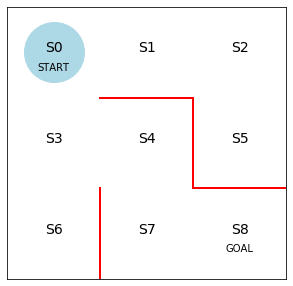

In [57]:
maze, line = make_maze()

In [58]:
anim = visualize(maze, line, state_history)
HTML(anim.to_jshtml())